In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import torch
import string
import unicodedata
# try to load the json data
import json
import torch.nn as nn
import time
import torch.optim as optim
from random import choice, choices, shuffle

import matplotlib.pyplot as plt

assert torch.cuda.is_available()

     |████████████████████████████████| 993kB 2.8MB/s 


In [2]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content with length "{}"'.format(len(downloaded.GetContentString())))

jsonObject = json.loads(downloaded.GetContentString())

print(type(jsonObject))
print(len(jsonObject))
print(jsonObject[0])

all_categories = []
articles_dict = dict()
for article in jsonObject:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
n_categories = len(articles_dict.keys())

weights_all_categories = []
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))
    weights_all_categories.append(len(articles_dict[category])/len(jsonObject))
print(weights_all_categories)

n_letters = len(string.printable)+1

def lineToTensor(text):
    tensor = torch.zeros(len(text), 1, n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[idx, 0, pos] = 1
    return tensor

print(lineToTensor("Ro"))
print(lineToTensor("ro").shape)

n_hidden = n_letters

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.lstm_layer = nn.LSTM(input_size, hidden_size, 1)
        
        
        self.lstm_to_classification = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        hidden , (h_t, c_t) = self.lstm_layer(input)
        output = self.lstm_to_classification(hidden[-1])
        return output
      
rnn=LSTM(n_letters, n_hidden, n_categories).cuda()

inp = lineToTensor("Rodrigo is my name")
output = rnn(inp.cuda())
print(output)

def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(rnn(lineToTensor("some random line here").cuda())))

def randomTrainingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(training_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomTestingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(testing_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomWeightedTrainingExample(use_first_n_characters=-1):
    # use the random.choices function with the weights computed earlier
    category = choices(all_categories, weights = weights_all_categories, k = 1)[0]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).cuda()
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()

randomWeightedTrainingExample()

def plot_losses(all_losses):
    plt.figure()
    plt.plot(all_losses)
    
def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

Downloaded content with length "669380879"
<class 'list'>
573371
{'id': 'http://arxiv.org/abs/1904.03835v4', 'category': 'Physics', 'subject': 'astro-ph.CO', 'title': 'Kaon oscillations and baryon asymmetry of the universe', 'abstract': 'Baryon asymmetry of the universe (BAU) is naturally explained with\n$K^0-K^{0\'}$ oscillations of a newly developed mirror-matter model and new\nunderstanding of quantum chromodynamics (QCD) phase transitions. A consistent\npicture for the origin of both BAU and dark matter is presented with the aid of\n$n-n\'$ oscillations of the new model. The global symmetry breaking transitions\nin QCD are proposed to be staged depending on condensation temperatures of\nstrange, charm, bottom, and top quarks in the early universe. The long-standing\nBAU puzzle can then be understood with $K^0-K^{0\'}$ oscillations that occur at\nthe stage of strange quark condensation and baryon number violation via a\nnon-perturbative instanton-like (coined "quarkiton") process. S

## 1st exp

100 1.0% (0.0m 48.86248207092285s) 2.259 / Statistics X Quantitative Biology
200 2.0% (1.0m 42.62180161476135s) 2.112 / Mathematics X Quantitative Finance
300 3.0% (2.0m 31.052385807037354s) 2.414 / Physics X Economics
400 4.0% (3.0m 19.915487051010132s) 1.979 / Quantitative Finance X Quantitative Biology
500 5.0% (4.0m 8.72267198562622s) 2.309 / Mathematics X Statistics
600 6.0% (4.0m 58.4695463180542s) 2.384 / Electrical Engineering and Systems Science X Quantitative Biology
700 7.0% (5.0m 47.720574140548706s) 1.793 / Statistics V
800 8.0% (6.0m 36.72365045547485s) 2.204 / Quantitative Finance X Quantitative Biology
900 9.0% (7.0m 25.10158610343933s) 2.065 / Computer Science X Physics
1000 10.0% (8.0m 13.820191860198975s) 2.152 / Quantitative Finance X Economics
1100 11.0% (9.0m 3.0485658645629883s) 2.331 / Economics X Mathematics
1200 12.0% (9.0m 52.55224370956421s) 2.063 / Physics X Statistics
1300 13.0% (10.0m 41.082112073898315s) 2.247 / Mathematics X Economics
1400 14.0% (11.0m 

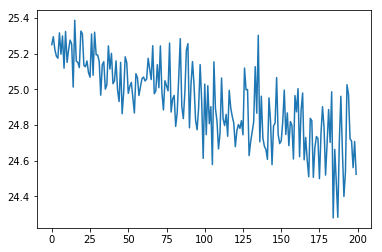

In [0]:
learning_rate = 0.01
rnn = LSTM(n_letters, n_hidden, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_batch_iters = 10000
batch_size = 12
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_batch_iters+1):
  
    optimizer.zero_grad()
    for _ in range(batch_size):
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample()
        output = rnn(abstract_tensor)
        loss = criterion(output, category_tensor)
        loss.backward()
        current_loss += loss.item()/batch_size
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

## Increase batch size

100 1.0% (1.0m 35.49302577972412s) 1.859 / Economics X Statistics
200 2.0% (3.0m 11.261245727539062s) 2.294 / Electrical Engineering and Systems Science X Statistics
300 3.0% (4.0m 47.46421670913696s) 1.869 / Economics V
400 4.0% (6.0m 22.953073024749756s) 2.187 / Computer Science X Quantitative Finance
500 5.0% (7.0m 59.46942472457886s) 1.978 / Electrical Engineering and Systems Science V
600 6.0% (9.0m 33.50765037536621s) 2.077 / Electrical Engineering and Systems Science X Physics
700 7.0% (11.0m 9.1635262966156s) 2.043 / Physics X Electrical Engineering and Systems Science
800 8.0% (12.0m 44.88895225524902s) 2.058 / Physics X Mathematics
900 9.0% (14.0m 20.539998292922974s) 1.736 / Economics V
1000 10.0% (15.0m 57.45032525062561s) 2.064 / Quantitative Biology X Statistics
1100 11.0% (17.0m 34.264235496520996s) 1.955 / Statistics X Quantitative Biology
1200 12.0% (19.0m 11.063005685806274s) 2.001 / Physics X Economics
1300 13.0% (20.0m 47.15663981437683s) 1.968 / Computer Science X 

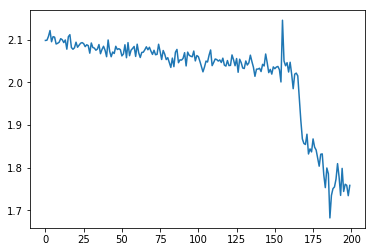

In [0]:
learning_rate = 0.01
rnn = LSTM(n_letters, n_hidden, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_batch_iters = 10000
batch_size = 24
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_batch_iters+1):
  
    optimizer.zero_grad()
    for _ in range(batch_size):
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample()
        output = rnn(abstract_tensor)
        loss = criterion(output, category_tensor)
        loss.backward()
        current_loss += loss.item()/batch_size
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

## Separation between training and testing data (41%)

100 0.5% (1.0m 40.15687322616577s) 2.213 / Statistics X Quantitative Biology
200 1.0% (3.0m 18.070382356643677s) 1.995 / Computer Science X Electrical Engineering and Systems Science
300 1.5% (4.0m 55.79259634017944s) 2.738 / Mathematics X Statistics
400 2.0% (6.0m 37.16757106781006s) 2.006 / Computer Science X Quantitative Finance
500 2.5% (8.0m 17.192092895507812s) 2.382 / Computer Science X Electrical Engineering and Systems Science
600 3.0% (9.0m 56.879350900650024s) 2.155 / Mathematics X Quantitative Biology
700 3.5% (11.0m 49.26926589012146s) 2.457 / Mathematics X Quantitative Biology
800 4.0% (14.0m 7.155445575714111s) 2.541 / Statistics X Physics
900 4.5% (16.0m 23.10714840888977s) 2.183 / Economics X Quantitative Biology
1000 5.0% (18.0m 36.16287875175476s) 2.056 / Statistics X Computer Science
1100 5.5% (20.0m 51.51445412635803s) 1.856 / Economics X Electrical Engineering and Systems Science
1200 6.0% (23.0m 5.2460761070251465s) 2.103 / Statistics X Physics
1300 6.5% (25.0m 1

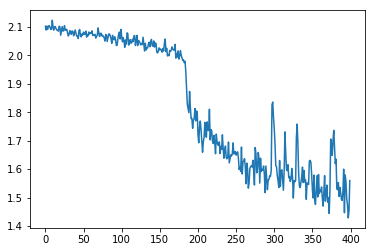

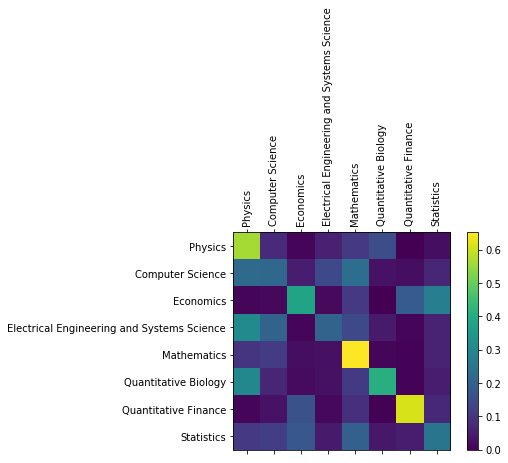

tensor([[56.,  7.,  1.,  5., 10., 15.,  0.,  2.],
        [22., 21.,  4., 14., 23.,  3.,  2.,  7.],
        [ 1.,  1., 38.,  1., 10.,  0., 19., 28.],
        [31., 20.,  0., 20., 14.,  4.,  0.,  6.],
        [ 9., 11.,  2.,  2., 65.,  1.,  0.,  6.],
        [30.,  6.,  1.,  2., 10., 41.,  0.,  5.],
        [ 1.,  3., 16.,  1.,  8.,  0., 61.,  7.],
        [10., 12., 17.,  4., 19.,  4.,  4., 25.]])


In [3]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01
rnn = LSTM(n_letters, n_hidden, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_batch_iters = 20000
batch_size = 24
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_batch_iters+1):
  
    optimizer.zero_grad()
    for _ in range(batch_size):
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample()
        if not abstract:
            continue
        output = rnn(abstract_tensor)
        loss = criterion(output, category_tensor)
        loss.backward()
        current_loss += loss.item()/batch_size
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

n_confusion = 10000
rights = 0
wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for i in range(n_confusion):
      category, abstract, category_tensor, abstract_tensor = randomTestingExample()
      cat_i = all_categories.index(category)
      output = rnn(abstract_tensor)
      guess, guess_i = categoryFromOutput(output)
      if guess_i == cat_i:
          rights += 1
      else:
          wrongs += 1
      confusion[cat_i][guess_i] += 1
print("{} accuracy out of {} tests".format(round(rights/(rights+wrongs),2), rights+wrongs))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)